PyTorch -  image classification - Beagle vs others dogs 
- https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/pytorch_classification.ipynb

Datasets caes: 
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
- https://pixabay.com/images/search/beagle/?pagi=3&
- https://www.istockphoto.com/pt/search/2/image?page=33&phrase=beagle
  

In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import time

cudnn.benchmark = True

In [2]:
m = nn.Linear(224,160)

In [3]:
input = torch.randn(224, 224)

In [4]:
output = m(input)
print(output.size())

torch.Size([224, 160])


In [5]:
dataset_directory = os.path.join(os.environ["HOME"], "projects_andreiapfsousa/ComputerVisionProjects/Breeds_project")


In [6]:
root_directory = os.path.join(dataset_directory, "Dog_images_beagle")

beagle_directory = os.path.join(root_directory, "beagle")
others_directory = os.path.join(root_directory, "others")

beagle_images_filepaths = sorted([os.path.join(beagle_directory, f) for f in os.listdir(beagle_directory)])
others_images_filepaths = sorted([os.path.join(others_directory, f) for f in os.listdir(others_directory)])
images_filepaths = [*beagle_images_filepaths, *others_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:1600]
val_images_filepaths = correct_images_filepaths[1600:-200]
test_images_filepaths = correct_images_filepaths[-200:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

1600 203 200


In [7]:
train_image=200/2003
print(train_image)

0.09985022466300549


In [28]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    correct_labels=[]
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        if true_label == predicted_label:
            correct_labels.append(predicted_label)
            
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    print("correct_labels:", len(correct_labels))

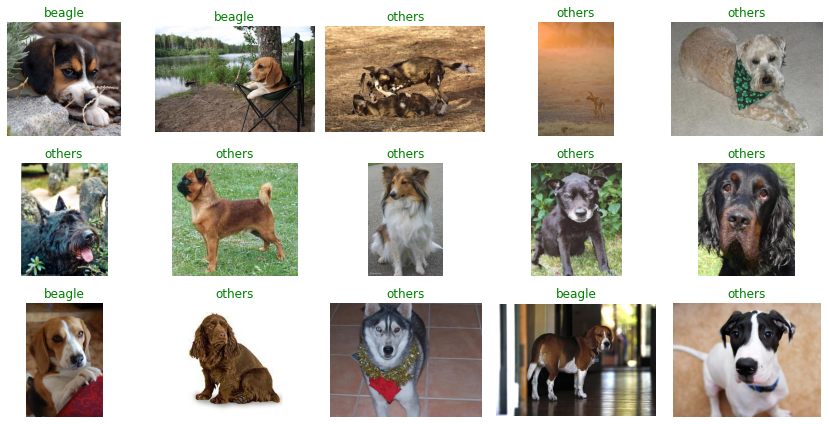

In [9]:
display_image_grid(test_images_filepaths[:15])

In [10]:
class beagleVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "beagle":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [11]:

train_transform = A.Compose(
    [
         A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=4, p=0.3),
        ], p=0.3),
        A.VerticalFlip(p=0.3), 
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.6),
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = beagleVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)


In [12]:
val_transform = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = beagleVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [13]:
def visualize_augmentations(dataset, idx=16, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

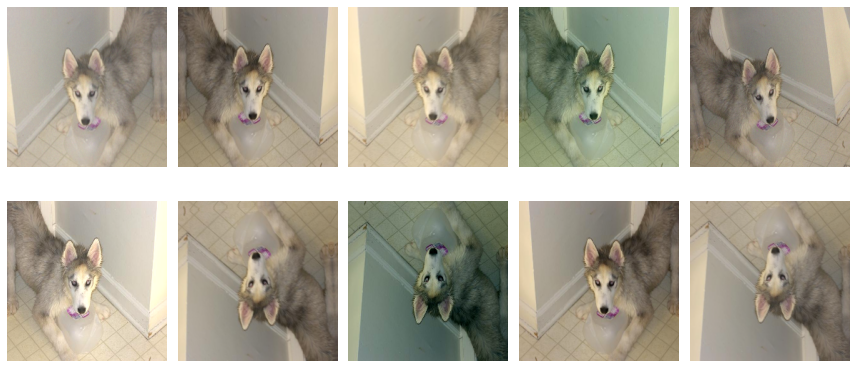

In [14]:
random.seed(42)
visualize_augmentations(train_dataset)

In [15]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [16]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [17]:
  # joao cunha rede:
  
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()      
        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.MaxPool2d(kernel_size=(2,2)), # kernel size
        nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.MaxPool2d(kernel_size=(2,2)), # kernel size
        nn.Flatten(),
        nn.Linear(in_features=200704, out_features=512),
        nn.Linear(in_features=512, out_features=1)
        )    

    def forward(self, x):
        x = self.model(x)
        #print (x.shape)
        #x = F.softmax(x, dim=1)
        return x

In [18]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True,
)
# for sample, label in train_loader:
#     print("labels of train_loader:", label)
#     print(sample.shape)
        
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, pin_memory=True,
)

# for sample, label in val_loader:
#     print("labels of val_loader:", label)
#     print(sample.shape)
        


In [19]:
params = {
    "device": "cpu",
    "epochs": 20
}

In [20]:
model = BinaryClassification()
model = model.to(params["device"])
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BinaryClassification(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=200704, out_features=512, bias=True)
    (10): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [21]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    since = time.time()
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)

    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [22]:
def validate(val_loader, model, criterion, epoch, params):
    since = time.time()
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)

    
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )


In [23]:
for epoch in range(1, params["epochs"]+ 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 161.401 | Accuracy: 0.525: 100%|██████████| 50/50 [03:33<00:00,  4.28s/it]
Epoch: 1. Validation. Loss: 66.048 | Accuracy: 0.467: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]
Epoch: 2. Train.      Loss: 36.356 | Accuracy: 0.551: 100%|██████████| 50/50 [03:41<00:00,  4.43s/it]
Epoch: 2. Validation. Loss: 19.464 | Accuracy: 0.605: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
Epoch: 3. Train.      Loss: 22.247 | Accuracy: 0.551: 100%|██████████| 50/50 [03:33<00:00,  4.28s/it]
Epoch: 3. Validation. Loss: 37.100 | Accuracy: 0.453: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
Epoch: 4. Train.      Loss: 29.789 | Accuracy: 0.552: 100%|██████████| 50/50 [03:37<00:00,  4.36s/it]
Epoch: 4. Validation. Loss: 37.213 | Accuracy: 0.582: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
Epoch: 5. Train.      Loss: 20.383 | Accuracy: 0.550: 100%|██████████| 50/50 [03:25<00:00,  4.11s/it]
Epoch: 5. Validation. Loss: 16.998 | Accuracy: 0.427: 100%|██████████| 7/7 [00:07<00:00, 

In [24]:
class beagleVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = beagleVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,  pin_memory=True,
)

In [30]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.8)[:, 0].cpu().numpy()
        predicted_labels += ["beagle" if beagle else "others" for beagle in predictions]

/var/folders/jt/3qvb06sx5vqbk5jw9f8kycjw0000gn/T/ipykernel_52629/3332341001.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


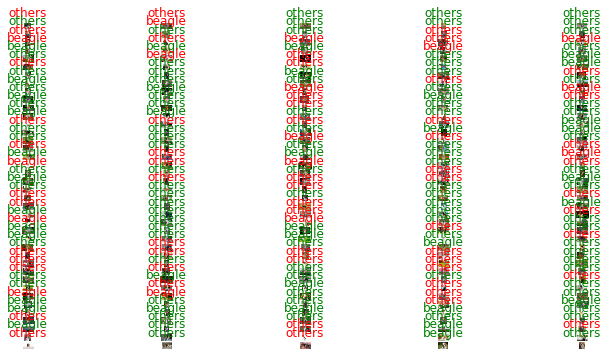

correct_labels: 126


In [31]:
display_image_grid(test_images_filepaths, predicted_labels)

In [32]:
print("Accuracy test dataet:",(126/200)*100)

Accuracy test dataet: 63.0


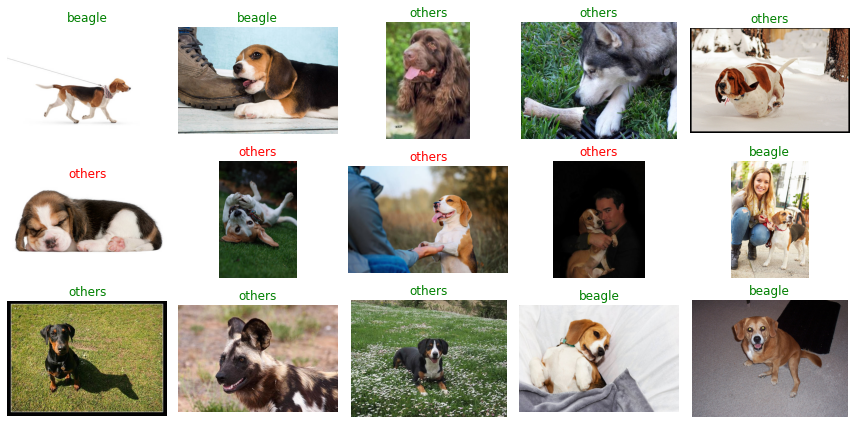

correct_labels: 11


In [34]:
display_image_grid(test_images_filepaths[60:75], predicted_labels[60:75])